## https://github.com/tiagomartins-threesigma/SINFO2023FRI4STARKs

In [3]:
%run Base.ipynb

prime = 12289


# FRI Commit Phase

### Define and Evaluate the Polynomial
At this point, let us define the polynomial $p_0$ through its coefficients, for the proper low-degree test.
The code below performs the sequence of operations:
1. it defines $c_0$ as an array of field elements,
2. computes the evaluation of $p_0$ by computing the $\texttt{FFT}$ of the array of coefficients.

In [19]:
c0 = Fp(np.eye(1, BUF*d0, 17, dtype=int).ravel())
p0 = np.fft.fft(c0)

print('c0 =',c0)
print('p0 =',p0)

c0 = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
p0 = [    1 10938  6429  2744  4134  6461  8668   949  8246  5777 11077  2975
 11567  4591  3504  9650  1479  4978  9094  3006  6553  7266  2545  2625
  5146  3328  1646   563  1305  6561  8747  4821 12288  1351  5860  9545
  8155  5828  3621 11340  4043  6512  1212  9314   722  7698  8785  2639
 10810  7311  3195  9283  5736  5023  9744  9664  7143  8961 10643 11726
 10984  5728  3542  7468]


### Sequence of Degree Respecting Projections
In the commit phase, the prover forms a sequence of polynomials that depend on the random challenges provided by the verifier and commits to the evaluation of each new polynomial at the moment of creation of the corresponding FRI layer. The last layer is an exception since the prover must provide the list of polynomial coefficients. The committing procedure is the prover-verifier interaction:

1. Starting with the original polynomial $p_0$, both the prover and the verifier must compute its degree bound $d_0$.
2. In sequence, for each FRI layer $i\ge 0$ such that $d_i>1$:
    1. the verifier provides a random challenges $z_{i,0}$ and $z_{i,1}$,
    2. the prover commits on the evaluation of $p_{i+1}$, 
    where supposedly $\mathrm{P}_{i+1}) = \mathrm{DRP}(\mathrm{P}_{i}, a_i, {\boldsymbol z}_i)$
    3. the degree bound is reduced as $d_{i+1}=d_i/2$.
3. The last step requires the prover to commit the $d_{\mathrm{LL}}$ polynomial coefficients of $p_{\mathrm{LL}}$. Where $\mathrm{LL}$ denotes the last layer state which is when the protocol first reaches 
$d_i\le 1$.


Layer 0
c = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
p = [    1 10938  6429  2744  4134  6461  8668   949  8246  5777 11077  2975
 11567  4591  3504  9650  1479  4978  9094  3006  6553  7266  2545  2625
  5146  3328  1646   563  1305  6561  8747  4821 12288  1351  5860  9545
  8155  5828  3621 11340  4043  6512  1212  9314   722  7698  8785  2639
 10810  7311  3195  9283  5736  5023  9744  9664  7143  8961 10643 11726
 10984  5728  3542  7468]
z = [5363 3847]

Layer 1
c = [   0    0    0    0    0    0    0    0 3847    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
p = [ 3847 12195  8442    94  3847 12195  8442    94  3847 12195  8442    94
  3847 12195  8442    94  3847 12195  8442    94  3847 12195  8442    94
  3847 12195  8442    94  3847 12195  8442    94]
z = [3707 5594]

Layer 2
c = [   0    0    0    0 5589    0    0    

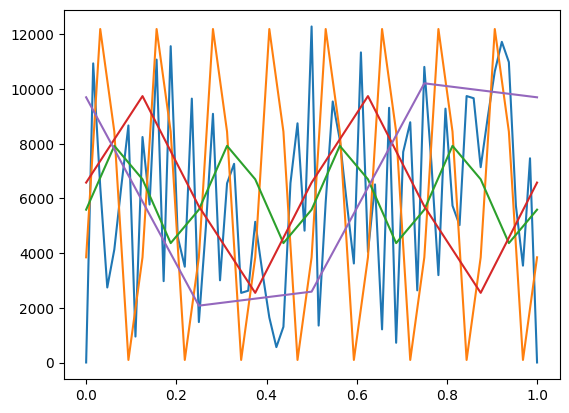

In [5]:
d = [d0]
c = [c0]
p = [p0]
z = []

while d[-1]>1:
    print_stuff(f'Layer {len(c)-1}', c[-1],p[-1])
    
    z.append(Fp(rand(prime-1, size=2)))
    print('z =', z[-1])
    c.append( z[-1][0]*c[-1][::2] + z[-1][1]*c[-1][1::2] )
    p.append(np.fft.fft(c[-1]))
    d.append(d[-1]//2)
        
print_stuff(f'Layer {len(c)-1} -> Last Layer', c[-1], p[-1])

### Commiting to the proof

Prover commits to the evaluation of $p_i$ for all $i \in \{0, \dotsc, \mathrm{LL}\}$.

In reality, commitments are implemented by building Merkle trees over the series of field elements and sending the Merkle roots to the verifier. 

But here, we will just "save" the lists $\texttt{p}$ and $\texttt{z}$ in an external file through Pickle object serialization.

In [6]:
import pickle
file = open('FRI_Commitment_File.out', 'wb')
pickle.dump({'p':p, 'z':z} , file)
file.close()

### Testing layer by layer

The following code defines a function $\texttt{test_layers}$ that takes in the number of the layer $\texttt{i}$ and the position along said layer $\texttt{sample}$.  

It performs the sequence of operations:
1. Compute the $x$ corresponding to the layer position $\texttt{sample}$
2. Define half of the length of the layer which is useful to locate $-x$ at position $\texttt{sample-halflength}$
3. Compute $g(x^2) = (p_i(x) + p_i(-x))/2$
4. Compute $h(x^2) = (p_i(x) - p_i(-x))/(2x)$
5. Print $x, p_i(x), p_i(-x)$
6. Compute $p_{i+1}(x^2)$ from $g(x^2)$ and $h(x^2)$ and print the result
7. Print the stored result of $p_{i+1}(x^2)$ where $x^2$ is located at position $\texttt{sample%halflength}$
8. Print the value of $x^2$


In [10]:
def test_layers(i, sample):
    x = Fp.primitive_element**(2**i*sample*(prime-1)//(BUF*d0))
    halflength = len(p[i])//2
    g = (p[i][sample]+p[i][sample-halflength])/Fp(2)
    h = (p[i][sample]-p[i][sample-halflength])/(Fp(2)*x)
    
    print('x =', x)
    print(f'p_{i}(x) =', p[i][sample])
    print(f'p_{i}(-x) =', p[i][sample-halflength])
    print(f'p_{i+1}(x^2) =', z[i][0]*g + z[i][1]*h)
    print(f'p_{i+1}(x^2) =', p[i+1][sample%halflength])
    print('x**2 =', x**2)

In [12]:
test_layers(0, 41)

x = 3328
p_0(x) = 6512
p_0(-x) = 5777
p_1(x^2) = 12195
p_1(x^2) = 12195
x**2 = 3195


In [11]:
test_layers(1, 41%32)

x = 3195
p_1(x) = 12195
p_1(-x) = 12195
p_2(x^2) = 7923
p_2(x^2) = 7923
x**2 = 8155


In [14]:
test_layers(2, 41%16)

x = 8155
p_2(x) = 7923
p_2(-x) = 7923
p_3(x^2) = 9742
p_3(x^2) = 9742
x**2 = 8246


In [15]:
test_layers(3, 41%8)

x = 8246
p_3(x) = 9742
p_3(-x) = 9742
p_4(x^2) = 2079
p_4(x^2) = 2079
x**2 = 1479
